# Building Chemical Reaction Networks (CRNs) Directly with BioCRNpyler

**Overview:**  This tutorial shows how to use [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) to represent simple CRNs

## What is a CRN?
A CRN is a widely established model of chemistry and biochemistry.
* A set of species $S$
* A set of reactions $R$ interconvert species $I_r$ to $O_r$
\begin{align}
\\
I \xrightarrow[]{\rho(s)} O
\\
\end{align}
 * $I$ and $O$ are multisets of species $S$. 
 * $\rho(s): S \to \mathbb{R}$ is a function that determines how fast the reaction occurs.


## Combining Species and Reactions into a CRN

The following code defines a species called 'S' made out of material 'material'. Species can also have attributes to help identify them. Note that Species with the same name, but different materials or attributes are considered different species in terms of the reactions they participate in.

    S = Species('name', material_type='material', attributes=[])

The collowing code produces a reaction R
    
    R = Reaction(Inputs, Outputs, k)

here `Inputs` and `Outputs` must both be a list of `Species`. The parameter `k` is the rate constant of the reaction. By default, propensities in BioCRNpyler are massa ction:

### $\rho(S) = k \Pi_{s} s^{I_s}$

Note: for stochastic models mass action propensities are $\rho(S) = k \Pi_{s} s!/(s - I_s)!$.

Mass action reactions can be made reversible with the `k_rev` keyword:

    R_reversible = Reaction(Inputs, Outputs, k, k_rev = krev)

is the same as two reactions:

    R = Reaction(Inputs, Outputs, k)
    Rrev = Reaction(Outputs, Inputs, krev)


Finally, a CRN can be made by combining species and reactions:

    CRN = ChemicalReactionNetwork(species=species, reactions=reactions, initial_condition_dict={})

Here, `initial_condition_dict` is an optional dictionary to store the initial values of different species. 

    initial_condition_dict = {Species: value}

Species without an initial condition will default to 0.

In [1]:
# Import required packages
from biocrnpyler import Species, Reaction, ChemicalReactionNetwork

# Example: Model the CRN consisting of: A --> 2B,
# 2B <--> B + C where C has the same name as B but a new material
A = Species("A", material_type = "m1", attributes = ["attribute"])
B = Species("B", material_type = "m1")
C = Species("B", material_type = "m2")
D = Species("D")

print("Species can be printed to show their string representation:", A, B, C, D)

# Reaction Rates
k1 = 3.
k2 = 1.4
k2rev = 0.15

# Reaciton Objects
R1 = Reaction.from_massaction([A], [B, B], k_forward = k1)
R2 = Reaction.from_massaction([B], [C, D], k_forward = k2)

print("\nReactions can be printed as well:\n", R1,"\n", R2)

#create an initial condition so A has a non-zero value
initial_concentration_dict = {A:10}

# Make a CRN
CRN = ChemicalReactionNetwork(species = [A, B, C, D], reactions = [R1, R2],
                              initial_concentration_dict = initial_concentration_dict)

# CRNs can be printed in two different ways
print("\nDirectly printing a CRN shows the string"
      "representation of the species used in BioCRNpyler:\n")
print(CRN)

print("\nCRN.pretty_print(...) is a function that prints a more customizable\n"
      "version of the CRN, but doesn't show the proper string representation of species:\n")
print(CRN.pretty_print(show_materials = True, show_rates = True, show_attributes = True))

Species can be printed to show their string representation: m1_A_attribute m1_B m2_B D

Reactions can be printed as well:
 m1[A(attribute)] --> 2m1[B] 
 m1[B] --> m2[B]+D

Directly printing a CRN shows the stringrepresentation of the species used in BioCRNpyler:

Species = m1_A_attribute, m1_B, m2_B, D
Reactions = [
	m1[A(attribute)] --> 2m1[B]
	m1[B] --> m2[B]+D
]

CRN.pretty_print(...) is a function that prints a more customizable
version of the CRN, but doesn't show the proper string representation of species:

Species(N = 4) = {
m1[A(attribute)] (@ 10),  D (@ 0),  m2[B] (@ 0),  m1[B] (@ 0),  
}

Reactions (2) = [
0. m1[A(attribute)] --> 2m1[B]
 Kf=k_forward * m1_A_attribute
  k_forward=3.0

1. m1[B] --> m2[B]+D
 Kf=k_forward * m1_B
  k_forward=1.4

]


## CRNs can be saved as SBML and simulated

To save a CRN as SBML:

    CRN.write_sbml_file("file_name.xml")

To simulate a CRN with bioscrape:

    Results, Model = CRN_expression.simulate_with_bioscrape(timepoints, initial_condition_dict=x0)

Where x0 is a dictionary: x0 = {species_name: initial_value}

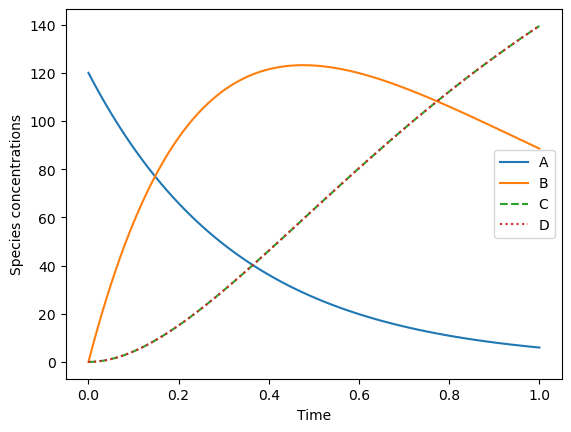

In [2]:
# Saving and simulating a CRN
CRN.write_sbml_file("build_crns_directly.xml")

try:
    import bioscrape
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    # Initial conditions can be set with a dictionary:
    x0 = {A:120}
    timepoints = np.linspace(0, 1, 100)#Timepoints to simulate over
    
    # This function can also take a filename keyword to save the file at the same time
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=x0)

    # Check to ensure simulation worked
    # Results are in a Pandas Dictionary and can be accessed via string-names of species
    plt.plot(R['time'], R[str(A)], label = "A")
    plt.plot(R['time'], R[str(B)], label = "B")
    plt.plot(R['time'], R[str(C)], "--", label = "C")
    plt.plot(R['time'], R[str(D)],":", label = "D")
    plt.xlabel("Time")
    plt.ylabel("Species concentrations")
    plt.legend()
    
except ModuleNotFoundError:
    print("Plotting Modules not installed.")

## ComplexSpecies and OrderedComplexSpecies

When `Species` bind together to form complexes, it is recommended to use the `Complex` function:

    from biocrnpyler import Complex
    Complex([list of species], ordered = True/False) 

This function returns the classes ComplexSpecies or OrderedComplexSpecies subclasses which contain information about the species inside of them. ComplexSpecies treats its internal species as an unordered multiset. OrderedComplexSpecies treats its internal species as an ordered list. It is recommended to always use the function Complex to create these types of Species for compatability reasons discussed in the OrderedPolymerSpecies example notebook.

_Note: These objects do not automatically generate binding reactions. To do that, use the Component wrappers ChemicalComplex and OrderedChemicalComplex._

In [3]:
from biocrnpyler import Complex 

A = Species("A", material_type = "m1")
B = Species("B", material_type = "m1")
B2 = Species("B", material_type = "m2")

print("\nFor ComplexSpecies, the order of the elements does not matter:")
C1 = Complex([A, B, B2, A])
C2 = Complex([B, A, B2, A])
print("C1=ComplexSpecies([A, B, B2, A])=", C1)
print("C2=ComplexSpecies([B, A, B2, A])=", C2)
print("C1==C2 ==>", C1==C2)

print("\nFor OrderedComplexSpecies, the Order Does Matter:")
C3 = Complex([A, B, B2, A], ordered = True)
C4 = Complex([B, A, B2, A], ordered = True)
print("C3=OrderedComplexSpecies([A, B, B2, A])=", C3)
print("C4=OrderedComplexSpecies([B, A, B2, A])=", C4)
print("C3==C4 ==>", C3==C4)

print("\nComplexSpecies (and the OrderedComplexSpecies and Multimers) are Species and can be used in reactions:")
R = Reaction.from_massaction([A, B, B2, A], [C1], k_forward=10)
print("Reaction.from_massaction([A, B, B2, A], [C1], k_forward = 10)=")
print(R)


For ComplexSpecies, the order of the elements does not matter:
C1=ComplexSpecies([A, B, B2, A])= complex_m1_A_2x_m1_B_m2_B_
C2=ComplexSpecies([B, A, B2, A])= complex_m1_A_2x_m1_B_m2_B_
C1==C2 ==> True

For OrderedComplexSpecies, the Order Does Matter:
C3=OrderedComplexSpecies([A, B, B2, A])= ordered_complex_m1_A_m1_B_m2_B_m1_A_
C4=OrderedComplexSpecies([B, A, B2, A])= ordered_complex_m1_B_m1_A_m2_B_m1_A_
C3==C4 ==> False

ComplexSpecies (and the OrderedComplexSpecies and Multimers) are Species and can be used in reactions:
Reaction.from_massaction([A, B, B2, A], [C1], k_forward = 10)=
2m1[A]+m1[B]+m2[B] --> complex[2x_m1[A]:m1[B]:m2[B]]


## Non-mass action propensities in BioCRNpyler
By default, BioCRNpyler assumes that propensities are mass action with only one parameter, the rate constant $k_{forward}$ (and optional reverse rate $k_{reverse}$. However, additional propensity types are also supported. These reactions are created in two steps: first a `Propensity` of the appropriate type is made, then a `Reaction` is made using that `Propensity`. These reactions are always created irreversibly. Examples are shown below:

## HillPositive: 
$\rho(s) = k \frac{s_1^n}{K^n+s_1^n}$

Requried parameters: rate constant $k$, offset $K$, Hill coefficient $n$, and hill species $s_1$.

In [4]:
from biocrnpyler import HillPositive

# Create the propensity
R = Species("R")
hill_pos  = HillPositive(k=1, s1=R, K=5, n=2)

# Create the reaction
r_hill_pos = Reaction([A], [B], propensity_type = hill_pos)

# Print the reaction
print(r_hill_pos.pretty_print())

m1[A] --> m1[B]
 Kf = k R^n / ( K^n + R^n )
  k=1
  K=5
  n=2



## HillNegative: 
$\rho(s) = k \frac{1}{K^n+s_1^n}$

Requried parameters: rate constant $k$, offset $K$, Hill coefficient $n$, and Hill species $s_1$.

In [5]:
# Create the propensity
R = Species("R")
hill_neg  = HillPositive(k=1, s1=R, K=5, n=2)

# Create the reaction
r_hill_neg = Reaction([A], [B], propensity_type = hill_neg)

# Print the reaction
print(r_hill_neg.pretty_print())

m1[A] --> m1[B]
 Kf = k R^n / ( K^n + R^n )
  k=1
  K=5
  n=2



## ProportionalHillPositive: 
$\rho(s, d) = k d \frac{s_1^n}{K^n + s_1^n}$

Requried parameters: rate constant $k$, offset $K$, Hill coefficient $n$, Hill species $s_1$, and proportional species $d$.

In [6]:
from biocrnpyler import ProportionalHillPositive
#create the propensity
R = Species("R")
D = Species("D")
prop_hill_pos  = ProportionalHillPositive(k=1, s1=R, K=5, n=2, d=D)

# Create the reaction
r_prop_hill_pos = Reaction([A], [B], propensity_type=prop_hill_pos)

# Print the reaction
print(r_prop_hill_pos.pretty_print())

m1[A] --> m1[B]
 Kf = k D R^n / ( K^n + R^n )
  k=1
  K=5
  n=2



## ProportionalHillNegative: 
$\rho(s, d) = k d \frac{1}{K^n + s_1^n}$

Requried parameters: rate constant $k$, offset $K$, Hill coefficient $n$, Hill species $s_1$, and proportional species $d$.

In [7]:
from biocrnpyler import ProportionalHillNegative
#create the propensity
R = Species("R")
D = Species("D")
prop_hill_neg  = ProportionalHillNegative(k=1, s1=R, K=5, n=2, d=D)

#create the reaction
r_prop_hill_neg = Reaction([A], [B], propensity_type=prop_hill_neg)

#print the reaction
print(r_prop_hill_neg.pretty_print())

m1[A] --> m1[B]
 Kf = k D / ( 1 + (R/K)^2 )
  k=1
  K=5
  n=2



## General Propensity: 
$\rho(s) = $ function of your choice

For general propensities, the function must be written out as a string with all species and parameters declared.

In [8]:
from biocrnpyler import ParameterEntry, GeneralPropensity

# Create some parameters - note that parameters will be discussed in the next lecture
k1 = ParameterEntry("k1", 1.11)
k2 = ParameterEntry("k2", 2.22)

# Create species
S = Species("S")

# Type the string as a rate then declare the species and parameters
general = GeneralPropensity(f'k1*2 - k2/{S}^2',
                            propensity_species=[S],
                            propensity_parameters=[k1, k2])

r_general = Reaction([A, B], [C1], propensity_type=general)

print(r_general.pretty_print())

m1[A]+m1[B] --> complex[2x_m1[A]:m1[B]:m2[B]]
k1*2 - k2/S^2
  k1=1.11
  k2=2.22



In [9]:
# End